In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture

import pymysql
import pymysql.cursors

import seaborn
import scipy

from sklearn.covariance import EmpiricalCovariance

import sys

sys.path.append(os.path.abspath(os.path.dirname('../code/')))

from Database import Database, Partition

Each Specialty has a primary ownership value, which determines how relevant they are for prescriptions.

The list of primary ownership values in their ordered weight values are:
    
    Family
    Clinic
    Hospital
    Healthcare
    Disciplinary
    Department

The weights of primary ownership values are set as: 3, 5, 7, 10, 12, 15 and 2 for the Unknown Specialty Code.

The specialty weights have been confirmed from the Kernel Density Estimation, so the formula can be confirmed.

Below mentioned are formulas derived by closely observing the Safety Factor distributions. The parameters involve:

    - Weight: Manually added parameter obtained by selective filtering
    - Median Count: Shows how far the Specialty prescriptions 
    have gone beyond the median value calculated in `claim_statistics`
    - NPI COUNT: No. of NPI Prescribers available for that drug within a state, please refer to `pa_drug_prescriptions`
    - SUPPLY PER CLAIM: A parameter which divides the total_day_supply by the claim_count, considered as a safety factor
    - STD_COST_PER_CLAIM: The STDDEV(SUM(drug_cost) / SUM(claim_count)) aggregated over specialty in a state provided in
    `state_wise_specialty` schema
    - DRUG_REDUCTION_PER_CLAIM: The ratio of difference between Standard Fill Count and Claim Count to the Claim Count

___________

These equations will undergo analysis before going to the likelihood estimation
___________

#### Equation for calculating Specialty Weights   (1)

The chebychev's probability must take control of Claim per DOLLAR because the realm in discussion is only Safety and Patient Care. The specialties are capable of going beyond the median, so the probability relevant to claims.

```mathematica

Specialty Weight = Weight ( Chebychev's Prob(Outliers such that | X - Mu | < k * Sigma) * Prob(Claim Count > Median | Specialty ) )

Specialty Weight = Weight x ( (1 - 1/k^2) * ( Net Median Count / NPI COUNT (state) ) )

```

Where, Weight is the selected scale
___________

#### Equation for calculating the contributing Drug factor for Specialties   (2)

```mathematica

Drug Factor for Spl = NPI COUNT x COST_PER_CLAIM x SUPPLY_PER_CLAIM x ( DRUG_REDUCTION_VALUE x Prob( Standard Fill Count > Claim Count ) + CLAIM_PER_DOLLAR x Prob(Prescriber == Opioid.Prescriber) ) # usually this probability is 1

Drug Factor for Spl = NPI COUNT x COST_PER_CLAIM x SUPPLY_PER_CLAIM x ( DRUG_REDUCTION_VALUE * DRUG REDUCTION COUNT / TOTAL INSTANCES + 1 x CLAIM_PER_DOLLAR ) 

```

In [ ]:
partition = Partition('PA')
database = Database(partition)

In [94]:
# SQL for extracting the State Wise Specialty Data, Mean cost per claim
state_wise_mean_data_sql = """
SELECT specialty_description, 
COUNT(DISTINCT npi) as npi_count FROM pa_state_spl_drug_npi
GROUP BY specialty_description; """

specialty_factor_sql = """
SELECT * FROM specialty_entropy
WHERE specialty_description = '{0}'; """

pa_state_wise_spl = """
SELECT specialty_description, mean_claim_count, mean_cost_per_claim,
    mean_supply_per_claim, std_cost_per_claim, std_supply_per_claim, 
    mean_claim_per_dollar, std_claim_per_dollar
FROM pa_state_wise_specialty
WHERE specialty_description = '{0}';
"""

# select all (x)
pa_x_values = """
SELECT specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost
FROM pa_state_spl_drug_npi 
WHERE specialty_description = '{0}'
"""

net_total_claim_count = 1258795672.00
net_total_30_day_fill_count = 1842106437.9756508

connection = pymysql.connect(user='root', password='root',
                              host='localhost',
                              db='drug_database')

info_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_information')

presc_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='prescription_aggregates')

aggregate_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_aggregates')

info_cursor = info_connection.cursor()

cursor = connection.cursor()

spl_weights = {}

# The weight is based on how far the claims have gone and the no. of allowable prescription drugs
# times the Supervised Entry for Specialties based on their Primary Ownership
def get_specialty_weight_values(specialty, npi_count):
    cursor = connection.cursor()
    cursor.execute(specialty_factor_sql.format(specialty))
    result = cursor.fetchone()
    weight = result[3]
    spl_weights[specialty] = weight
    cursor.close()
    return (weight * get_chebychevs_probability(specialty, 'claim') *  (result[6] / npi_count))

info_cursor.execute(state_wise_mean_data_sql)
state_data = info_cursor.fetchall()
info_cursor.close()

spl_dict= {}
for item in state_data:
    spl_dict[item[0]] = item[1]
    
# agg_append = pd.DataFrame(columns=['specialty_description', 'mean_claim_count', 'mean_cost_per_claim',
#                             'mean_supply_per_claim', 'std_cost_per_claim', 'std_supply_per_claim',
#                             'mean_claim_per_dollar', 'std_claim_per_dollar'])

# drug_agg_append = pd.DataFrame(columns=['drug_name', 'mean_claim_count', 'mean_cost_per_claim',
#                             'mean_supply_per_claim', 'std_cost_per_claim', 'std_supply_per_claim',
#                             'mean_claim_per_dollar', 'std_claim_per_dollar'])

agg_append = dict()

def get_aggregated_values():
    global agg_append
    idx = 0
    for key in spl_dict.keys():
        specialty = key
        info_cursor = info_connection.cursor()
        info_cursor.execute(pa_state_wise_spl.format(specialty))
        agg_values = info_cursor.fetchone()
        agg_append[specialty] = agg_values
        info_cursor.close()
        idx = idx + 1

get_aggregated_values()

# An sgn function
def determine_zero_value(mean, sigma):
    if(mean < sigma and sigma - mean >= mean):
        return mean
    elif(sigma < mean and mean - sigma >= sigma):
        return sigma
    elif(mean > sigma and mean - sigma <= sigma):
        return mean - sigma
    elif(sigma > mean and sigma - mean <= mean):
        return sigma - mean
    return mean

x_append = dict()
# Returns a Dictionary of numpy arrays
# if else clauses for selecting the non-zero element
def get_all_x_values(specialty):
    global x_append
    try:
        info_cursor = database.info_connection.cursor()
        info_cursor.execute(database.x_values(specialty))
        x_values = info_cursor.fetchone()
        x_append[specialty] = np.array([])
        while(x_values):
            mean_claim_count, mean_cost_per_claim, mean_supply_per_claim, std_cost_per_claim, std_supply_per_claim, mean_claim_per_dollar, std_claim_per_dollar = [None] * 7
            specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost = x_values
            if(total_claim_count == 0):
                new_cursor = database.info_connection.cursor()
                new_cursor.execute(database.get_unit_values(drug_name))
                values = new_cursor.fetchall()
                mean_claim_count, mean_cost_per_claim, mean_supply_per_claim, std_cost_per_claim, std_supply_per_claim, mean_claim_per_dollar, std_claim_per_dollar = values[0]
                drug_cost = determine_zero_value(mean_cost_per_claim, std_cost_per_claim)
                total_day_supply = determine_zero_value(mean_supply_per_claim, std_supply_per_claim)
                total_claim_count = 1
                new_cursor.close()
            if(drug_cost == 0):
                new_cursor = database.info_connection.cursor()
                new_cursor.execute(database.get_unit_values(drug_name))
                values = new_cursor.fetchall()
                mean_claim_count, mean_cost_per_claim, mean_supply_per_claim, std_cost_per_claim, std_supply_per_claim, mean_claim_per_dollar, std_claim_per_dollar = values[0]
                total_claim_count = determine_zero_value(mean_claim_per_dollar, std_claim_per_dollar)
                drug_cost = 1
                new_cursor.close()
            np.append(x_append[specialty], 
            [total_claim_count / drug_cost, 
            total_day_supply / total_claim_count, 
            drug_cost / total_claim_count])
            x_values = info_cursor.fetchone()
        info_cursor.close()
    except Exception as e:
        print("Exception: ", x_values, specialty)
    return x_append[specialty]

def get_chebychevs_probability(specialty, domain='supply'):
    # from the dataframe
    x_values = get_all_x_values(specialty)
    mu = agg_append[specialty]
    if(domain == 'supply'):
        std_value = mu[5]
        mu_value = mu[3]
    elif(domain == 'cost'):
        std_value = mu[4]
        mu_value = mu[2]
        mu_value = mu_value[0]
    elif(domain == 'claim'):
        std_value = mu[7]
        mu_value = mu[6]
    
    count = 0
    ratio = 0
    for value in x_values;
        if (abs(value - mu_value) / std_value) > 1:
            ratio = ratio + abs( value - mu_value ) / std_value # Ratio of those which are exceeding
            count = count + 1
        ratio = ratio / count
    
    k = None
    if (ratio >= 2):
        k = floor(ratio)
    
    if (k == None): 
        return 1
    else:
        return (1 - 1/k**2)
    
spl_grid_weights = dict()
for item in iter(state_data):
    spl_grid_weights[item[0]] = get_specialty_weight_values(item[0], spl_dict[item[0]])


Exception:  ('Dentist', 'ATORVASTATIN CALCIUM', 11, 330.0, 0.0) Dentist
Exception:  ('Hematology/Oncology', 'SULFAMETHOXAZOLE-TRIMETHOPRIM', 12, 162.0, 0.0) Hematology/Oncology


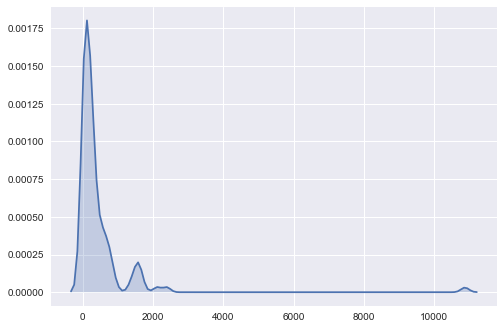

In [39]:
plotting_data = pd.Series(list(spl_grid_weights.values()))
ax = seaborn.kdeplot(plotting_data, kernel='gau', shade=True)

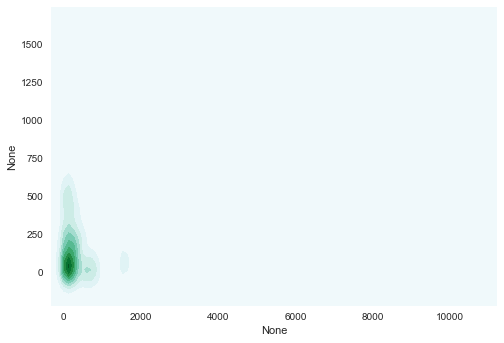

In [40]:
# Calculating the net cost of drugs that each specialties handle
cursor = info_connection.cursor()
cursor.execute("""
SELECT SUM(EXP(total_drug_cost / POW(10,8)))
FROM pa_cost_quality_table
GROUP BY specialty_description;
""")

spl = []
data = cursor.fetchone()
while(data):
    spl.append(data[0])
    data = cursor.fetchone()

specialty_data = pd.Series(spl)
ax = seaborn.kdeplot(plotting_data, specialty_data, kernel='gau', shade=True)

In [3]:
# Calculating the Drug factor for Specialty

state_wise_mean_data_sql = """
SELECT drug_name, mean_claim_count, mean_cost_per_claim, mean_supply_per_claim, 
std_cost_per_claim, std_supply_per_claim, mean_claim_per_dollar, 
std_claim_per_dollar FROM pa_state_wise_drug
WHERE drug_name = '{0}'; """

drug_prescriptions_sql = """
SELECT drug_name, claim_count, opioid_prescriber_count, npi_count, day_supply FROM pa_drug_prescriptions
WHERE drug_name = '{0}' AND nppes_provider_state = '{1}' """

pa_drug_factor_vector = """
SELECT * FROM pa_drug_factor_vector 
WHERE specialty_description = '{0}';
"""

state_wise_drug = """
SELECT DISTINCT(drug_name) FROM pa_cost_quality_table;
"""

info_cursor = info_connection.cursor()    

info_cursor.execute(state_wise_drug)

state_drug_data = info_cursor.fetchall()
info_cursor.close()

drug_agg_append = dict()

drug_dict = {}
for item in state_drug_data:
    drug_dict[item[0]] = item[0]

def get_drug_reduction(specialty):
    cursor = connection.cursor()
    cursor.execute(pa_drug_factor_vector.format(specialty))
    vector = cursor.fetchone()
    cursor.close()
    return vector

def get_drug_aggregated_values():
    global drug_agg_append
    for key in drug_dict.keys():
        drug = key
        cursor = info_connection.cursor()
        cursor.execute(state_wise_mean_data_sql.format(drug))
        agg_values = cursor.fetchone()
        drug_agg_append[drug] = agg_values
        cursor.close()
        
get_drug_aggregated_values()

def get_drug_factor_spl(drug, specialty):
    cursor = info_connection.cursor()
    cursor.execute(drug_prescriptions_sql.format(drug, 'PA'))
    result = cursor.fetchone()
    mu = drug_agg_append[drug]
    supply_per_claim = float(mu[3])
    cost_per_claim = float(mu[2])
    claim_per_dollar = float(mu[6])
    opioid_prescriber_count = result[2]
    npi_count = result[3]
    cursor.close()
    vector = get_drug_reduction(specialty) # count and reduction
    
    return float(npi_count) * cost_per_claim * supply_per_claim * (
        float(opioid_prescriber_count / npi_count) * claim_per_dollar + 
        float(vector[2]) * float(vector[3]) / float(result[1])
    )

pa_cost_quality_table = """
SELECT specialty_description, drug_name 
FROM pa_cost_quality_table GROUP BY specialty_description, drug_name;
"""

cursor = info_connection.cursor()
cursor.execute(pa_cost_quality_table)
item = cursor.fetchone()
drug_factor_spl = pd.DataFrame(columns=['specialty_description', 'drug_name', 'factor'])
while(item):
    drug_factor_spl = drug_factor_spl.append({'specialty_description': item[0], 
                            'drug_name': item[1], 
                            'factor': get_drug_factor_spl(item[1], item[0])}, ignore_index=True)
    item = cursor.fetchone()


Specialty values are found to be having an appropriate density plot with the joint distribution. This implies the values of specialty weights can be used for the Hypotheses.

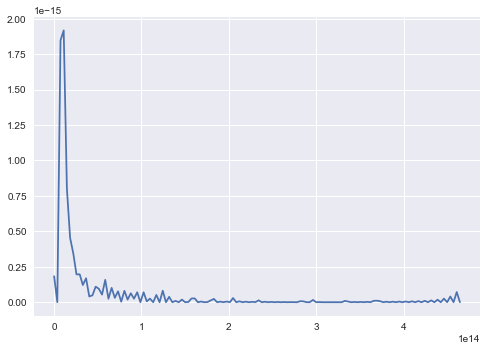

In [38]:
drug_plotting_data = pd.Series(drug_factor_spl['factor'].get_values())
seaborn.kdeplot(drug_plotting_data, kernel='gau')

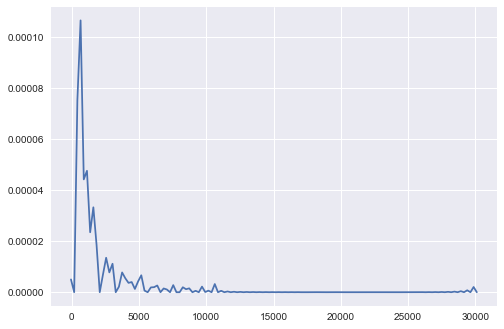

In [41]:
# Graphing the Standard Deviation of cost per claim for drugs
drug_data = []
for item in drug_agg_append.values():
    drug_data.append(item[4])

# KDE plot for usage (claim_count) and supply
seaborn.kdeplot(pd.Series(drug_data), kernel='gau')

# Plot data with Claim per Dollar and Mean Cost
# seaborn.kdeplot(drug_plotting_data, drug_data, kernel='gau')

__________

#### Equation for calculating the contributing Specialty factor for Drugs   (3)

```mathematica

Spl Factor for Drug = DRUG COUNT x SUPPLY_PER_CLAIM x ( NPI_COUNT x Prob(Claim is a Beneficiary) + DRUG_WEIGHT x AVG(Beneficiary Risk Scores OVER NPIs) )

```

#### Equation for calculating Drug Weights   (4)

```mathematica

Drug Weight = Weight x ( 1 / tanh(Claim Count OVER Health Risk AGGREGATED OVER NPIs) ) x Entropy(Health Risk OVER Claim Count AGGREGATED OVER NPIs)

```

[1.01]
[1.01]


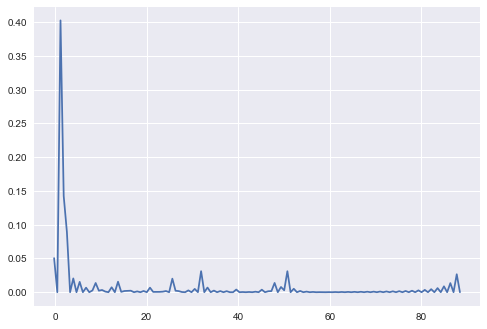

In [31]:
# Calculating the Drug Weights

import math

# Drugs Weights from Health and Drug Influence Grid, calculated using drug types
drug_manual_weights = {
    'HRM': 5,
    'antipsychotic': 4,
    'opioid': 3,
    'antibiotic': 2,
    'generic': 1,
    'other': 1
}

# field names for claim count
field_names = {
    'HRM': 'hrm_claim_count_ge65',
    'antipsychotic': 'antipsych_claim_count_ge65',
    'opioid': 'opioid_claim_count',
    'antibiotic': 'antibiotic_claim_count',
    'generic': 'generic_claim_count',
    'other': 'other_claim_count',
    'brand': 'brand_claim_count'
}

pa_cost_quality_sql = """
SELECT specialty_description, drug_name FROM pa_cost_quality_table GROUP BY specialty_description, drug_name;
"""

pa_cost_quality_where = """
SELECT specialty_description, drug_name FROM pa_cost_quality_table GROUP BY drug_name;
"""

info_cursor = info_connection.cursor()
info_cursor.execute(pa_cost_quality_where)
distinct_spl = info_cursor.fetchall()
info_cursor.close()
distinct_spl_dict = {}
for item in distinct_spl:
    if item[1] not in distinct_spl_dict:
        distinct_spl_dict[item[1]] = []
    distinct_spl_dict[item[1]].append(item[0])

find_drug_type = """
SELECT drug_name, category
FROM drug_categories
"""

cursor = aggregate_connection.cursor()
cursor.execute(find_drug_type)
categories = cursor.fetchall()
cursor.close()
category_array = {}
for item in categories:
    category_array[item[0]] = item[1]

def npi_drug_state_table_summary(drug, specialty, drug_type):
    drug_type = str.lower(drug_type)
    cursor = presc_connection.cursor()
    query = """
    SELECT IF(AVG(`""" + drug_type + """`) = 0, 1.01, 
    AVG(`""" + drug_type + """`)) FROM pa_pres_drug_risk
    GROUP BY specialty_description
    HAVING specialty_description = '""" + specialty + """'"""
    cursor.execute(query)
    ratio = cursor.fetchone()
    cursor.close()
    return ratio[0]

main_cursor = info_connection.cursor()
main_cursor.execute(pa_cost_quality_sql)
spl_drug_items = main_cursor.fetchall()
main_cursor.close()

def calculate_entropy(probability):
    return np.float64(probability * math.log(probability)) + np.float64((1 - probability) * math.log(1 - probability))

# returns average of Claim Count Over Health Risk
def get_drug_weight(drug, drug_type):
    drug_item = distinct_spl_dict[drug]
    ratio = []
    for item in drug_item:
        value = npi_drug_state_table_summary(drug, item, drug_type)
        ratio.append(value)
    return math.fsum(ratio) / len(ratio)

agg_ratio = []
for item in drug_dict.keys():
    if item not in category_array:
        drug_type = 'generic'
    else:
        drug_type = category_array[item]
    agg_ratio.append(get_drug_weight(item, drug_type))

# Plotting aggregate ratio
seaborn.kdeplot(pd.Series(agg_ratio))

-0.693134804578 0.0101003434547 1
2063


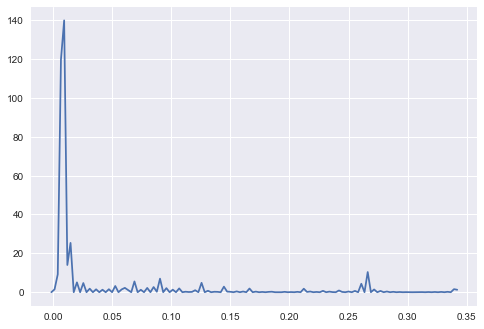

In [32]:
# Plotting Drugs Weights for Each Drug
drug_weights = pd.DataFrame(columns=['drug_name', 'factor'])
idx = 0
try:
    for item in drug_dict.keys():
        if item not in category_array:
            drug_type = 'generic'
        else:
            drug_type = category_array[item]
        drug_weights = drug_weights.append({'drug_name': item, 'factor': -1 * np.float64(
                calculate_entropy(1 / ( 1 + agg_ratio[idx] )) * np.float64(math.atanh(agg_ratio[idx] / 100)) *
                drug_manual_weights[drug_type])}, ignore_index=True)
        idx = idx + 1
except Exception as e:
    print(idx, agg_ratio[idx])
    raise e

print(len(drug_weights['factor'].values.tolist()))
drugs_all = dict(zip(drug_dict.keys(), drug_weights['factor'].values.tolist()))
# Plotting drug weights
seaborn.kdeplot(pd.Series(drug_weights['factor'].values.tolist()))

In [68]:
# Calculating Specialty Factor for Drug

pa_cost_quality_sql = """
SELECT specialty_description, COUNT(DISTINCT drug_name) as drug_count
FROM pa_cost_quality_table GROUP BY specialty_description;
"""

cursor = info_connection.cursor()
cursor.execute(pa_cost_quality_sql)
pa_cost_quality_dict = {}
pa_cost_quality = cursor.fetchall()
for item in pa_cost_quality:
    pa_cost_quality_dict[item[0]] = item[1]
cursor.close()

pa_cost_quality_query = """
SELECT specialty_description, drug_name, AVG(total_bene_count / total_claim_count) as average
FROM pa_cost_quality_table
GROUP BY specialty_description, drug_name
HAVING average != 0;
"""

cursor = info_connection.cursor()
cursor.execute(pa_cost_quality_query)
pa_cost_quality_bene = {}
pa_cost_quality = cursor.fetchall()
for item in pa_cost_quality:
    pa_cost_quality_bene[item[0].__str__() + "___" + item[1].__str__()] = item[2]
cursor.close()

bene_risk_sql = """
SELECT specialty_description, 
IF(AVG(beneficiary_average_risk_score) = 0, 0.01, AVG(beneficiary_average_risk_score)) as risk
FROM table_summary
WHERE nppes_provider_state = 'PA'
GROUP BY specialty_description;
"""

risk_value_dict = {}
presc_cursor = presc_connection.cursor()
presc_cursor.execute(bene_risk_sql)
risk = presc_cursor.fetchall()
for item in risk:
    risk_value_dict[item[0]] = item[1]
presc_cursor.close()

def get_spl_factor_drug(spl, drug):
    global pa_bene
    try:
        mu = agg_append[spl]
        supply_per_claim = mu[3]
        if (spl + "___" + drug) not in pa_cost_quality_bene or pa_cost_quality_bene[spl + "___" + drug] == 0:
            bene_count = float(0.000001)
        else:
            bene_count = float(pa_cost_quality_bene[spl + "___" + drug])

        drug_weight = drugs_all[drug]
        
        value = pa_cost_quality_dict[spl] * supply_per_claim * (float(spl_dict[spl]) * bene_count + float(drug_weight) * float(risk_value_dict[spl]))
    except Exception as e:
        print(spl, drug, pa_cost_quality_dict[spl], supply_per_claim, spl_dict[spl], bene_count, drug_weight, risk_value_dict[spl])
        raise e
    return value

spl_factor_drugs = pd.DataFrame(columns=['specialty_description', 'drug_name', 'factor'])
idx = 0
for item in iter(spl_drug_items):
    value = get_spl_factor_drug(item[0], item[1])
    spl_factor_drugs = spl_factor_drugs.append({'specialty_description': item[0], 'drug_name': item[1], 'factor': value}, 
                                              ignore_index=True)
    idx = idx + 1

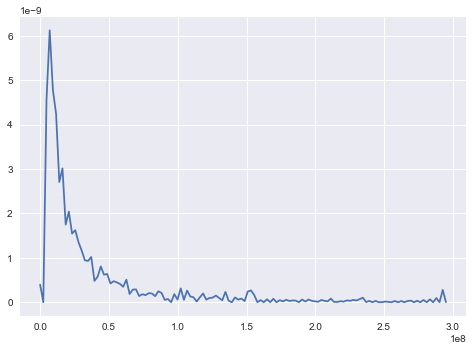

In [70]:
spl_plotting_data = pd.Series(spl_factor_drugs['factor'].get_values())
seaborn.kdeplot(spl_plotting_data, kernel='gau')

In [81]:
# PearsonR and Kendall Tau for Specialty weights and Specialty Factor for Drugs 
# The Specialty Influence

print("-- PearsonR and Kendall Tau for Specialty weights and Specialty Factor for Drugs --")
pa_cqt_vector = {'x': [], 'y': []}
values = spl_factor_drugs['factor'].get_values()
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_vector['x'].append(spl_grid_weights[item[0]])
    pa_cqt_vector['y'].append(values[idx])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_vector['x'], y=pa_cqt_vector['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_vector['x'], y=pa_cqt_vector['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Specialty weights and Specialty Factor for Drugs --
The PearsonR Correlation Coefficient is found to be: 
(-0.082344774294323853, 1.4996360986642939e-35)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=-0.21938194486513912, pvalue=0.0)


In [83]:
# PearsonR and Kendall Tau for Specialty weights and Drug weights, factor variables
# The Lambda vector

print("-- PearsonR and Kendall Tau for Specialty weights and Drug weights --")
pa_cqt_vector = {'x': [], 'y': []}
drug_weights_values = dict(zip(drug_dict.keys(), drug_weights['factor'].get_values().tolist()))
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_vector['x'].append(spl_grid_weights[item[0]])
    pa_cqt_vector['y'].append(drug_weights_values[item[1]])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_vector['x'], y=pa_cqt_vector['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_vector['x'], y=pa_cqt_vector['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Specialty weights and Drug weights --
The PearsonR Correlation Coefficient is found to be: 
(-0.016882665331070246, 0.010857410362125284)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=0.019395116948557427, pvalue=3.3701992646414896e-05)


In [85]:
# PearsonR and Kendall Tau for Factor weights
# The Safety Vector

print("-- PearsonR and Kendall Tau for Factor weights, the Safety Factor --")
pa_cqt_weights = {'x': [], 'y': []}
drug_factors = drug_factor_spl['factor'].values.tolist()
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_weights['x'].append(spl_grid_weights[item[0]])
    pa_cqt_weights['y'].append(drug_factors[idx])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Factor weights, the Safety Factor --
The PearsonR Correlation Coefficient is found to be: 
(-0.045233174075921825, 8.6235668144017419e-12)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=-0.36369449938877108, pvalue=0.0)


In [87]:
# PearsonR and Kendall Tau for Factor weights
# The Drug Influence

print("-- PearsonR and Kendall Tau for Factor weights, the Drug Influence --")
pa_cqt_weights = {'x': [], 'y': []}
drug_factors = drug_factor_spl['factor'].values.tolist()
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_weights['x'].append(drug_factors[idx])
    pa_cqt_weights['y'].append(drug_weights_values[item[1]])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Factor weights, the Drug Influence --
The PearsonR Correlation Coefficient is found to be: 
(-0.0061511386304779064, 0.353394172866909)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=-0.02664660719461661, pvalue=7.920752796585659e-09)


In [89]:
# PearsonR and Kendall Tau for Factor weights
# The z vector

print("-- PearsonR and Kendall Tau for Factor weights, the z vector --")
pa_cqt_weights = {'x': [], 'y': []}
drug_factors = drug_factor_spl['factor'].values.tolist()
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_weights['x'].append(drug_factors[idx])
    pa_cqt_weights['y'].append(values[idx])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Factor weights, the z vector --
The PearsonR Correlation Coefficient is found to be: 
(-0.007196619862840474, 0.27758431566858432)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=0.2265254247348012, pvalue=0.0)


In [90]:
# PearsonR and Kendall Tau for Factor weights
# The Health vector

print("-- PearsonR and Kendall Tau for Factor weights, the Health vector --")
pa_cqt_weights = {'x': [], 'y': []}
idx = 0
for item in iter(spl_drug_items):
    pa_cqt_weights['x'].append(drug_weights_values[item[1]])
    pa_cqt_weights['y'].append(values[idx])
    idx = idx + 1

corr_coeff = scipy.stats.pearsonr(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The PearsonR Correlation Coefficient is found to be: \n" + corr_coeff.__str__())

kendall_tau = scipy.stats.kendalltau(x=pa_cqt_weights['x'], y=pa_cqt_weights['y'])

print("The kendall Tau Ranking Correlation Coefficient is found to be: \n" + kendall_tau.__str__())

-- PearsonR and Kendall Tau for Factor weights, the Health vector --
The PearsonR Correlation Coefficient is found to be: 
(0.0073564393326496719, 0.26705300030069984)
The kendall Tau Ranking Correlation Coefficient is found to be: 
KendalltauResult(correlation=0.14535493380261949, pvalue=3.5902550791413201e-217)


#### Writing to the `pa_factors` database for the state 'PA'
```sql
CREATE TABLE IF NOT EXISTS `pa_factors` (
  `nppes_provider_state` varchar(128) NOT NULL,
  `specialty_description` varchar(128) NOT NULL,
  `drug_name` varchar(128) NOT NULL,
  `specialty_weight` double NOT NULL,
  `drug_weight` double NOT NULL,
  `drug_factor_specialty` double NOT NULL,
  `specialty_factor_drug` double NOT NULL,
  KEY `specialty_description` (`specialty_description`),
  KEY `drug_name` (`drug_name`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;
```

In [104]:
cursor = presc_connection.cursor()
def insert_pa_factors():
    return """
    INSERT INTO pa_factors VALUES ('PA', '{0}', '{1}', '{2}', '{3}', '{4}', '{5}')
    """

spl_factor_drugs_dict = spl_factor_drugs.to_dict()
drug_factor_spl_dict = drug_factor_spl.to_dict()
idx = 0
try:
    presc_connection.begin()
    for item in iter(spl_drug_items):
        cursor.execute(insert_pa_factors().format(item[0], item[1], 
        spl_grid_weights[item[0]], drug_weights_values[item[1]], 
        drug_factor_spl_dict['factor'][idx], spl_factor_drugs_dict['factor'][idx]))
        cursor = presc_connection.cursor()
        idx = idx + 1
        if idx % 100:
            presc_connection.commit()
except Exception as e:
    presc_connection.rollback()
    raise e
cursor.close()